# Preprocessing Text Fields

This assignment walks through the basics of cleaning text fields with regex and pandas.

### Importing Libraries and Dataset

First, we import the necessary libraries and dataset. The dataset we are using for this assignment is [Kaggle's spam SMS dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset). The only modifications that we've done to the dataset are to encode the CSV using UTF-8 so that it can be read by pandas, change ham and spam labels to 0 and 1 respectively, as well as clean up the dataset column labels. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from IPython.display import display

sns.set()

In [2]:
sms = pd.read_csv("spam.csv")
sms.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1, inplace = True)
sms.rename(columns = {"v1": "label", "v2": "text"}, inplace = True)
sms["label"] = sms["label"].map({"ham": 0, "spam": 1})
sms.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### Exploratory Data Analysis

Let's first just look at the counts of the how many spam and ham labels we have.

In [3]:
sms.groupby(by = ["label"]).count()

,text
label,
0,4825
1,747


Since we have a class imbalance, a naive classifier that always outputs ham is able to achieve an accuracy of 87%. To discourage this, we use the area under the ROC curve (AUROC) as our metric instead of just accuracy. A perfect classifier will have an AUROC of 1, while a naive classifier has an AUROC of 0.5. We can confirm this by calculating the ROC of our naive always ham classifier below. 

You do not need to understand how this metric works, as it is not the goal of this assignment.

In [4]:
fpr, tpr, thresholds = metrics.roc_curve(sms["label"], [0] * len(sms.index))
metrics.auc(fpr, tpr)

0.5

This shows that the naive classifier indeed has an AUROC of 0.5. Let's see if we can do better than that by processing the text!

Next, let's take a look at some of these text entries to see if we can find any differences between spam and ham texts by just reading them. 

In [5]:
print("First 15 Ham Texts:\n")
for i, ham_text in enumerate(sms.loc[sms["label"] == 0]["text"][:15]):
    print("{}. {}\n".format(i + 1, ham_text))

First 15 Ham Texts:

1. Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

2. Ok lar... Joking wif u oni...

3. U dun say so early hor... U c already then say...

4. Nah I don't think he goes to usf, he lives around here though

5. Even my brother is not like to speak with me. They treat me like aids patent.

6. As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune

7. I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.

8. I've been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times.

9. I HAVE A DATE ON SUNDAY WITH WILL!!

10. Oh k...i'm watching here:)

11. Eh u remember how 2 spell his name... Yes i did. He v naughty make unti

In [6]:
print("First 15 Spam Texts:\n")
for i, spam_text in enumerate(sms.loc[sms["label"] == 1]["text"][:15]):
    print("{}. {}\n".format(i + 1, spam_text))

First 15 Spam Texts:

1. Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

2. FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv

3. WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.

4. Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030

5. SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info

6. URGENT! You have won a 1 week FREE membership in our å£100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18

7. XXXMobileMovieClub: To use your credit

From this initial inspection of our dataset, we can see that our dataset isn't perfectly labeled. The sixth text in the ham texts is clearly a spam, despite being labeled as a ham text. Despite that, we can still see at least some differences in the texts. Spam texts generally contain more numbers (either phone numbers or codes), links, and miscellaneous capitalization/punctuation compared to ham texts.

Let's see if we can use these indicators as features for a classifier!

### Finding Phone Numbers

Our classifier's first feature will be the number of digits of the longest number in the text. For example, a phone number like 09061209465 will have a length of 11. Add this feature as a column called "longestNum" to the `sms` dataframe. 

*Hint: To apply regex to a pandas series, look into series.str.function.*<br>
*Hint: Try to first find all numbers for a single text, and then search for the maximum length one.*

In [7]:
# BEGIN STUDENT SOLUTION

# END STUDENT SOLUTION

Let's plot the distribution of this new feature for spam and ham texts:

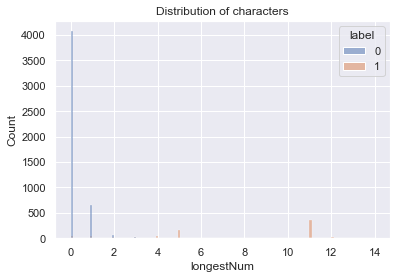

In [8]:
sns.histplot(
    data = sms,
    x = "longestNum",
    hue = "label"
)
plt.title("Distribution of characters")
plt.show()

From this plot, we can observe that this feature is pretty helpful in separating our data, as spam features tend to have longer numbers than ham texts.

### Finding Links

In addition to just having numbers with more digits, spam texts also generally have more links than ham texts. However, one problem with trying to identify links is that they don't all take the same format. Links could have "http", "www", etc. as the prefix and ".com", ".net", etc. as the suffix. To simplify our search, assume that links will always have the following structure: 

"www" / "http" | text (at least 1 character) | ".com" / ".net"
Prefix         | domain                      | suffix

Note that the only character the text cannot contain is a space. Additionally, while the last part is referred to as a suffix, we do not require there to be a space after the suffix. Add a {0, 1} indicator for if text contains a link as a column called "containsLink" to the `sms` dataframe. 

*Hint: The pipe (|) operator serves as an or.*<br>
*Hint: Parentheses may be helpful.*

In [9]:
# BEGIN STUDENT SOLUTION

# END STUDENT SOLUTION 

C:\Users\kevin\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Let's take a look at these counts: 

In [10]:
sms.drop("longestNum", axis = 1).groupby(by=["label", "containsLink"]).count()

text
label containsLink      
0     0             4823
      1                2
1     0              697
      1               50

We can see that in total, we only found 52 links in our entire dataset; while this is far lower than we might have hoped, it's also not entirely unexpected, as we're looking at spam texts instead of spam emails. Additionally, despite the low counts, links are much more prevalent for spam texts as opposed to ham texts. We will keep this feature in, but will be far less helpful than our first feature. 

### Magic Words

One very naive way to process text is to have some features be indicators for if "magic words" you believe to be good separators exist in a piece of text. For example, "free" might be a good magic word, since many spam texts from our initial selection use that word. We define the set of the following magic words: {"txt", "claim", "confirm", "free", "reply", "xxx", "reward", "award"}. Let our magic words be case insensitive, so "Free" and "free" both count towards the indicator.

However, we want to avoid having too many false positives on our indicator. Create two separate features, "magicWordsOnce" and "magicWordsTwice". The first feature indicates if any of the magic words appear in our text. The second feature indicates if at least two words from the text are in our magic words set. They do not have to be unique either, so a text that's just "free free" would also activate this indicator. Add both of these {0, 1} indicators to the `sms` dataframe. 

*Hint: Don't overcomplicate the regex for this problem.*<br>
*Hint: str.lower() converts the string into lowercase.*

In [11]:
# BEGIN STUDENT SOLUTION

# END STUDENT SOLUTION

C:\Users\kevin\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Let's take a look at these counts:

In [12]:
sms.loc[:,["text", "label", "magicWordsOnce"]].groupby(by=["label", "magicWordsOnce"]).count()

text
label magicWordsOnce      
0     False           4656
      True             169
1     False            278
      True             469

In [13]:
sms.loc[:,["text", "label", "magicWordsTwice"]].groupby(by=["label", "magicWordsTwice"]).count()

text
label magicWordsTwice      
0     0                4806
      1                  19
1     0                 516
      1                 231

We can see that these are much better indicators than using just links, since these indicators for our magic words are much more likely to go off. 

### Evaluating our Features

Now that we've processed our text, let's try to see how well our classifier performs using just these three features. We split our data into a train and test set and train a basic logistic regression classifier on the data. 

In [14]:
X, y = sms.drop(["label", "text"], axis = 1), sms["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [15]:
model = LogisticRegression().fit(X_train, y_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, model.predict(X_train))
train_auc = metrics.auc(fpr, tpr)
fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict(X_test))
test_auc = metrics.auc(fpr, tpr)

print("Train AUROC: ", train_auc)
print("Test AUROC: ", test_auc)

Train AUROC:  0.9426433953358273
Test AUROC:  0.932358870967742


Given that you've added your features correctly, you should have an AUROC above 0.9. This shows that our classifier is fairly capable, despite using a simple model! Hopefully these exercises provide a good foundation on how to process text with pandas and regex. 

As for some additional practice, one aspect of regex that this assignment did not take advantage of is capture groups. While the features didn't really care about what the exact matches were (ie. our features didn't need to know what the link matched was or what phone number was included in the spam mail); there are certain applications where the match's exact value is vital.

### Bonus: Multiple One-Hot Encoding on Magic Words

As a bonus exercise, let's see what happens when we use one-hot encoding on our magic words instead of just indicator features. One-hot encoding is the process of transforming a categorical feature into one that a model can actually use. Suppose you have a feature with $l$ distinct labels. Then one-hot encoding creates the following transformation: 
<li> Replace the categorical feature with $l$ indicator features.</li>
<li> For a given data point, if a feature is label $i$, where $i \in \{1,2,...,l\}$, set the $i$th indicator to 1.</li>
<li> Set all remaining indicators to 0.</li>

Shown below is an example of one-hot encoding on a dummy dataset. 

In [16]:
# Dummy dataset
df = pd.DataFrame({"city": ["Berkeley", "San Francisco", "Berkeley", "Oakland", "Berkeley", "San Francisco"]})
df

,city
0,Berkeley
1,San Francisco
2,Berkeley
3,Oakland
4,Berkeley
5,San Francisco


In [17]:
# Dummy dataset after encoding 
df = pd.get_dummies(df, columns = ["city"])
df

,city_Berkeley,city_Oakland,city_San Francisco
0,1,0,0
1,0,0,1
2,1,0,0
3,0,1,0
4,1,0,0
5,0,0,1


Now, let's try to use one-hot encoding on our magic words. However, if you remember from the original prompt, it's possible that multiple magic words can be found in a single text instead of just 1. You can visualize this in context of the dummy dataset as if you had a data point that contained a list of cities like `["Berkeley", "San Francisco"]`. To encode this, we would use multiple one-hot encoding, where the indicators for Berkeley and San Francisco would both be on for that specific data point. 

We've removed your original magic word indicator features. Try to create this multiple one-hot encoding for your dataset, and add the features at the right end of your DataFrame. The names of the features should correspond to the magic word. Note that there should be 8 new features added, since there are 8 magic words. 

*Hint: You may find sklearn's MultiLabelBinazer useful.*<br>
*Hint: You can concatenate two DataFrames horizontally with `pd.concat`.*

In [18]:
sms.drop(["magicWordsOnce", "magicWordsTwice"], axis = 1, inplace = True)

# BEGIN STUDENT SOLUTION

# END STUDENT SOLUTION

Let's take a look at the counts for each magic word. 

In [19]:
for column in sms.columns[-8:]:
    display(sms.loc[:,["text", "label", column]].groupby(by=["label", column]).count())

text
label award      
0     0      4824
      1         1
1     0       689
      1        58

text
label claim      
0     0      4825
1     0       631
      1       116

text
label confirm      
0     0        4809
      1          16
1     0         746
      1           1

text
label free      
0     0     4759
      1       66
1     0      548
      1      199

text
label reply      
0     0      4781
      1        44
1     0       649
      1        98

text
label reward      
0     0       4823
      1          2
1     0        737
      1         10

text
label txt      
0     0    4809
      1      16
1     0     569
      1     178

text
label xxx      
0     0    4790
      1      35
1     0     725
      1      22

From the data above, you should be able to see how often each magic word shows up in each category. Which magic words are better at separating the classes?

We can run our classifier again with our new features and view the new AUROC. 

In [20]:
X, y = sms.drop(["label", "text"], axis = 1), sms["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [21]:
model = LogisticRegression().fit(X_train, y_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, model.predict(X_train))
train_auc = metrics.auc(fpr, tpr)
fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict(X_test))
test_auc = metrics.auc(fpr, tpr)

print("Train AUROC: ", train_auc)
print("Test AUROC: ", test_auc)

Train AUROC:  0.9420387684802842
Test AUROC:  0.9377472527472528


The performance of your classifier should not substantially change. This means that there's not a huge difference between using indicators for each magic word and for the counts of magic words. 